In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import pandas_ta as ta
import yfinance as yf

from datetime import datetime, timedelta

%matplotlib inline
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import notebook_utils

from invaas.schwab.cnn_fear_greed_index import get_current_cnn_fear_greed_index, get_historical_cnn_fear_greed_index

product_ids = ["SPY"]
# product_ids = ["VOO", "VGT", "VUG", "VTI", "VT"]
# product_ids = ["VGT"]
# product_ids = ["GBTC", "ETHE"]

In [2]:
def get_df_fear_greed_index():
    print("Retrieving historical fear and greed index")
    import json

    with open("data/cnn_fear_greed_index_data.json") as f:
        cnn_fear_greed_index_data = json.load(f)

    df_fear_greed_index = pd.DataFrame(
        data=cnn_fear_greed_index_data["data"]["c:50108"]["series"][0], columns=["x", "y"]
    )
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(x, unit="s", tz="UTC") for x in df_fear_greed_index.x]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"y": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_history(product_id):
    print(f"Retrieving historical data for {product_id}")

    df_history = yf.Ticker(product_id).history(interval="1d", period="5y")[:-1]
    df_history.columns = map(str.lower, df_history.columns)

    timestamps = [pd.to_datetime(x, utc=True).round(freq="D") for x in df_history.index.values]
    timestamps_date_range = pd.date_range(start=timestamps[0], end=timestamps[-1], freq="D")
    df_history = df_history.set_index(pd.DatetimeIndex(timestamps)).reindex(timestamps_date_range, method="ffill")

    df_history = df_history.join(df_fear_greed_index[["fear_greed_index"]], how="inner")
    df_history["fear_greed_index"] = df_history.fear_greed_index.fillna(method="ffill").astype(float)

    def get_strategy_length(x):
        return x * 1

    for column in ["close", "fear_greed_index"]:
        for days in [5, 7, 10, 14, 20, 30, 60, 90, 120]:
            periods = get_strategy_length(days)
            df_history[f"{column}_previous"] = df_history[column].shift(1)
            df_history[f"{column}_min_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).min()
            df_history[f"{column}_max_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).max()
            df_history[f"{column}_gradient_{days}"] = df_history[column].diff(periods=periods) / periods
            df_history[f"{column}_gradient_min_{days}"] = (
                df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).min()
            )
            df_history[f"{column}_gradient_max_{days}"] = (
                df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).max()
            )

    CustomStrategy = ta.Strategy(
        name="Momo and Volatility",
        ta=[
            {"kind": "sma", "length": get_strategy_length(10)},
            {"kind": "sma", "length": get_strategy_length(20)},
            {"kind": "sma", "length": get_strategy_length(50)},
            {"kind": "bbands", "length": get_strategy_length(20)},
            {"kind": "rsi", "length": get_strategy_length(5)},
            {"kind": "rsi", "length": get_strategy_length(7)},
            {"kind": "rsi", "length": get_strategy_length(10)},
            {"kind": "rsi", "length": get_strategy_length(14)},
            {"kind": "rsi", "length": get_strategy_length(20)},
            {"kind": "rsi", "length": get_strategy_length(30)},
            {
                "kind": "macd",
                "fast": get_strategy_length(8),
                "slow": get_strategy_length(21),
            },
            {
                "kind": "sma",
                "close": "volume",
                "length": get_strategy_length(10),
                "prefix": "VOLUME",
            },
            {
                "kind": "sma",
                "close": "volume",
                "length": get_strategy_length(20),
                "prefix": "VOLUME",
            },
            {
                "kind": "sma",
                "close": "volume",
                "length": get_strategy_length(50),
                "prefix": "VOLUME",
            },
            # {"kind": "sma", "close": "fear_greed_index", "length": get_strategy_length(10)},
            # {"kind": "sma", "close": "fear_greed_index", "length": get_strategy_length(20)},
            # {"kind": "sma", "close": "fear_greed_index", "length": get_strategy_length(50)},
            # {"kind": "bbands", "close": "fear_greed_index", "length": get_strategy_length(20)},
            # {"kind": "rsi", "length": get_strategy_length(7)},
            # {"kind": "rsi", "length": get_strategy_length(14)},
            # {"kind": "rsi", "length": get_strategy_length(30)},
            # {
            #     "kind": "macd",
            #     "close": "fear_greed_index",
            #     "fast": get_strategy_length(8),
            #     "slow": get_strategy_length(21),
            # },
        ],
    )
    df_history.ta.strategy(CustomStrategy)
    df_history["SMA_20_prev"] = df_history.SMA_20.shift(1)

    return df_history


df_fear_greed_index = get_df_fear_greed_index()
history_dfs = {}

for product_id in product_ids:
    history_dfs[product_id] = get_df_history(product_id)

Retrieving historical fear and greed index
Retrieving historical data for SPY


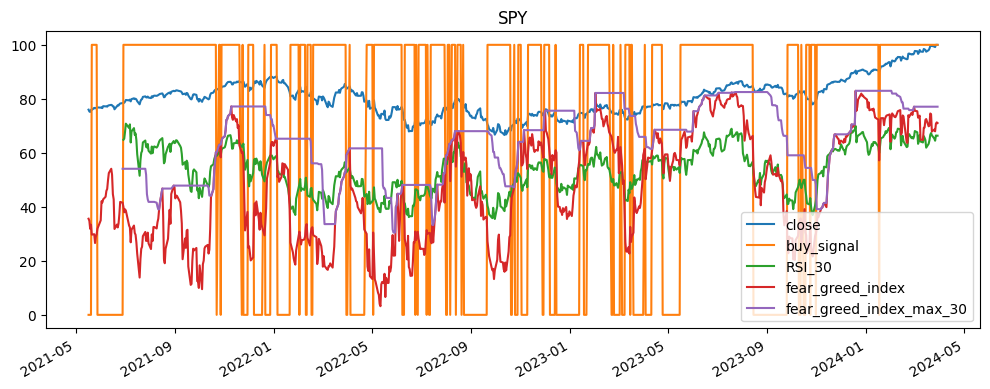

In [3]:
total_products = len(history_dfs)
fig, ax = plt.subplots(nrows=total_products, figsize=(10, 4 * total_products))
days = 30

for product_index, product_id in enumerate(product_ids):
    ax_index = ax if total_products <= 1 else ax[product_index]
    df_history1 = history_dfs[product_id][["close"]].copy()
    # df_history2 = history_dfs[product_id][[f"close_gradient_{days}", f"close_gradient_min_{days}", f"close_gradient_max_{days}"]].copy()
    df_history3 = history_dfs[product_id][[f"RSI_{days}", "fear_greed_index", f"fear_greed_index_max_{days}"]].copy()
    # df_history4 = history_dfs[product_id][[f"fear_greed_index_gradient_{days}", f"fear_greed_index_gradient_min_{days}", f"fear_greed_index_gradient_max_{days}"]].copy()
    df_history5 = history_dfs[product_id][["BBP_20_2.0"]].copy()

    df_history1_max = df_history1.to_numpy()[~np.isnan(df_history1.to_numpy())].max()
    # df_history2_max = df_history2.to_numpy()[~np.isnan(df_history2.to_numpy())].max()
    df_history3_max = df_history3.to_numpy()[~np.isnan(df_history3.to_numpy())].max()
    # df_history4_max = df_history4.to_numpy()[~np.isnan(df_history4.to_numpy())].max()
    df_history5_max = df_history5.to_numpy()[~np.isnan(df_history5.to_numpy())].max()

    for column in df_history1.columns:
        df_history1[column] = df_history1[column] / df_history1_max * 100

    # for column in df_history2.columns:
    #     df_history2[column] = df_history2[column] / df_history2_max * 100

    # for column in df_history3.columns:
    #     df_history3[column] = df_history3[column] / df_history3_max * 100

    # for column in df_history4.columns:
    #     df_history4[column] = df_history4[column] / df_history4_max * 100

    # for column in df_history5.columns:
    #     df_history5[column] = df_history5[column] / df_history5_max * 100

    df_history = (
        df_history1
        # .join(df_history2, how="outer")
        .join(df_history3, how="outer")
        # .join(df_history4, how="outer")
        .join(df_history5, how="outer")
    )
    # df_history = history_dfs[product_id]
    df_history["buy_signal"] = (
        (df_history[f"RSI_{days}"] > df_history[f"fear_greed_index_max_{days}"])
        | ((df_history[f"RSI_{days}"] > 50) & (df_history.fear_greed_index > 60))
        | (df_history.fear_greed_index < 30)
    ).replace({True: 100, False: 0})
    df_history["sell_signal"] = ((df_history[f"RSI_{days}"] > 75) | (df_history.fear_greed_index < 30)).replace(
        {True: 100, False: 0}
    )

    df_history[
        [
            "close",
            "buy_signal",
            # "sell_signal",
            f"RSI_{days}",
            # "BBP_20_2.0",
            "fear_greed_index",
            f"fear_greed_index_max_{days}",
            # f"close_min_{days}", f"close_max_{days}",
            # f"close_gradient_{days}", f"close_gradient_min_{days}", f"close_gradient_max_{days}",
            # f"fear_greed_index_min_{days}", f"fear_greed_index_max_{days}",
            # f"fear_greed_index_gradient_{days}", f"fear_greed_index_gradient_min_{days}", f"fear_greed_index_gradient_max_{days}"
            # "buy_signal", "sell_signal"
        ]
    ].plot(ax=ax_index)

    ax_index.set_title(product_id)

plt.legend()
plt.tight_layout()
plt.show()

# df_history = history_dfs[product_id]
# display(df_history.corr().astype(str)[["period_max_close_pct_change"]])
# display(df_history.describe())

Total fee percentage: 0%
Start money: $1000
Min buy amount: $2
Max buy amount: $100
End money: $1551.46
Pct earned: 55.146%
Total orders: 527
Avg pct earned per order: 0.105%
Total volume: $43441.57
Total days: 1047.0
Avg 30 day volume: $1244.74


,product_id,side,amount,coins,value,money,total_balance
timestamp,,,,,,,
2021-05-21 00:00:00+00:00,SPY,buy,100.0,0.2534905622573533,394.49200439453125,900.0,1000.0
2021-05-24 00:00:00+00:00,SPY,buy,90.0,0.22583924698196392,398.5135498046875,810.0,1001.019423807164
2021-05-25 00:00:00+00:00,SPY,buy,81.0,0.2037072583098028,397.6294250488281,729.0,1000.5956364565941
2021-05-26 00:00:00+00:00,SPY,buy,72.9,0.18297345093699333,398.41845703125,656.1,1001.1345745480701
2021-05-27 00:00:00+00:00,SPY,buy,65.61,0.16458967196417887,398.627685546875,590.49,1001.3157686433685
...,...,...,...,...,...,...,...
2024-03-25 00:00:00+00:00,SPY,buy,2.0,0.003872109772799516,516.5142822265625,9.313799916794444,1541.719003158711
2024-03-26 00:00:00+00:00,SPY,buy,2.0,0.0038792750841458662,515.5602416992188,7.313799916794444,1538.88853608643
2024-03-27 00:00:00+00:00,SPY,buy,2.0,0.0038469458410415867,519.8929443359375,5.313799916794444,1551.759695188736


,product_id,side,total_orders
0,SPY,buy,494
1,SPY,sell,33


<Axes: xlabel='timestamp'>

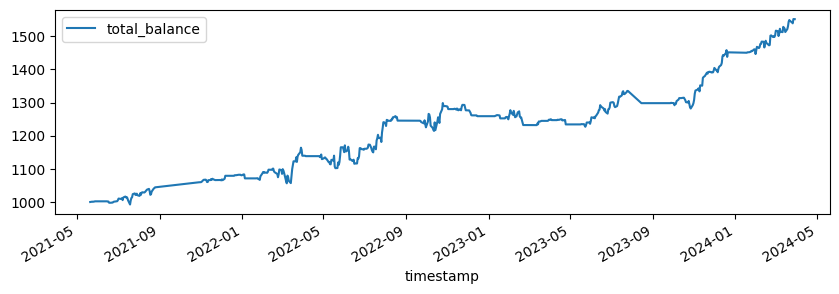

In [4]:
fee_pct = 0
p_keep = 1 - (fee_pct / 2 / 100)
print(f"Total fee percentage: {fee_pct}%")

coins = {}
coins_hold = {}
min_hold = 0
max_hold = 0

for product_id in product_ids:
    coins[product_id] = 0
    coins_hold[product_id] = 0

money = 1000
start_money = money
print(f"Start money: ${start_money}")

min_buy_amount = 2
max_buy_amount = 100
print(f"Min buy amount: ${min_buy_amount}")
print(f"Max buy amount: ${max_buy_amount}")

total_orders = 0
total_volume = 0
orders = []

total_products = len(product_ids)

# feat_greed_schedule = [
#     {'threshold': 0, 'factor': 1, 'action': 'buy'},
#     {'threshold': 30, 'factor': 1, 'action': 'buy'},
#     # {'threshold': 40, 'factor': 0.25, 'action': 'buy'},
#     # {'threshold': 60, 'factor': 0.25, 'action': 'sell'},
#     {'threshold': 70, 'factor': 1, 'action': 'sell'},
#     {'threshold': 100, 'factor': 1, 'action': 'sell'}
# ]

for product_id in product_ids:
    history_dfs[product_id]["product_id"] = product_id

df_final = pd.concat([history_dfs[product_id] for product_id in product_ids]).sort_index()

for index, row in df_final.iterrows():
    product_id = row.product_id

    def get_total_balance():
        total_balance = money

        for coin_product_id in product_ids:
            df_final_product_period = df_final.loc[(df_final.index == index) & (df_final.product_id == coin_product_id)]

            if len(df_final_product_period) > 0:
                total_balance += coins[coin_product_id] * df_final_product_period.close.values[-1] * p_keep

        return total_balance

    def floor_value(x: float, precision: int):
        return np.true_divide(np.floor(x * 10**precision), 10**precision)

    condition_action = None
    condition_factor = None

    if (
        # (row.RSI_30 > row.fear_greed_index_max_30 or (row.RSI_30 > 50 and row.fear_greed_index > 60))
        # (row.RSI_20 > row.fear_greed_index_max_20 or (row.RSI_20 > 50 and row.fear_greed_index > 60))
        # (row.RSI_14 > row.fear_greed_index_max_14 or (row.RSI_14 > 50 and row.fear_greed_index > 60))
        # (row.RSI_5 > row.fear_greed_index_max_5 or (row.RSI_5 > 50 and row.fear_greed_index > 60))
        # and (coins[product_id] * row.close) < 1000
        # and money >= min_buy_amount
        # (row.RSI_10 > row.fear_greed_index_max_10 or (row.RSI_10 > 50 and row.fear_greed_index > 60))
        # and pd.to_datetime(index, utc=True) != pd.to_datetime(df_final.index.values[-1], utc=True)
        (row.fear_greed_index < 30)
        or (row.RSI_20 < 30)
        or (
            (row.fear_greed_index >= 30)
            and (row.RSI_20 >= 30)
            and ((row.RSI_20 > row.fear_greed_index_max_20) or ((row.RSI_20 > 50) and (row.fear_greed_index > 60)))
        )
    ):
        condition_action = "buy"
    # elif (
    #     row.RSI_7 < row.fear_greed_index
    #     # or (coins[product_id] * row.close) > 1000
    #     # or money < min_buy_amount
    #     or pd.to_datetime(index, utc=True) == pd.to_datetime(df_final.index.values[-1], utc=True)
    # ):
    else:
        condition_action = "sell"

    if condition_action == "buy":
        # condition_factor = (100 - row.fear_greed_index) / 100
        condition_factor = 1
        # buy_amount = floor_value(money / len(product_ids) * condition_factor, 2)
        buy_amount = floor_value(money / len(product_ids) / 10, 2)
        buy_amount = buy_amount if buy_amount >= min_buy_amount else min_buy_amount
        buy_amount = buy_amount if buy_amount <= max_buy_amount else max_buy_amount

        if money >= buy_amount and buy_amount > 0:
            money -= buy_amount
            buy_coins = buy_amount / row.close * p_keep
            coins[product_id] += buy_coins
            coins_hold[product_id] = 0
            total_orders += 1
            total_volume += buy_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "buy",
                    "amount": buy_amount,
                    "coins": buy_coins,
                    "value": row.close,
                    "money": money,
                    "total_balance": get_total_balance(),
                    # "fear_greed_index": row.fear_greed_index
                }
            )
    elif condition_action == "sell" and coins_hold[product_id] > -1:
        # condition_factor = row.fear_greed_index / 100
        condition_factor = 1
        sell_coins = floor_value(coins[product_id] * condition_factor, 8)
        coins[product_id] = coins[product_id] - sell_coins
        sell_amount = sell_coins * row.close * p_keep

        if sell_amount > 0:
            total_orders += 1
            total_volume += sell_amount
            money += sell_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "sell",
                    "amount": sell_amount,
                    "coins": sell_coins,
                    "value": row.close,
                    "money": money,
                    "total_balance": get_total_balance(),
                    # "fear_greed_index": row.fear_greed_index
                }
            )

    coins_hold[product_id] += 1

money += sum(
    [
        (coins[product_id] * df_final.loc[df_final.product_id == product_id].close.values[-1] * p_keep)
        for product_id in product_ids
    ]
)

print(f"End money: ${money:.2f}")
pct_earned = (money - start_money) / start_money * 100
print(f"Pct earned: {pct_earned:.3f}%")
days = (df_final.index.values[-1] - df_final.index.values[0]).astype("timedelta64[D]") / np.timedelta64(1, "D")
print(f"Total orders: {total_orders}")
print(f"Avg pct earned per order: {pct_earned / total_orders:.3f}%")
print(f"Total volume: ${total_volume:.2f}")
print(f"Total days: {days}")
print(f"Avg 30 day volume: ${(total_volume / days * 30):.2f}")

df_orders = pd.DataFrame(orders)
df_orders.set_index("timestamp", inplace=True)
display(df_orders.astype(str))

orders_info = []
for product_id in product_ids:
    for side in ["buy", "sell"]:
        df_orders_product_side = df_orders.loc[(df_orders.product_id == product_id) & (df_orders.side == side)]
        orders_info.append(
            {
                "product_id": product_id,
                "side": side,
                "total_orders": len(df_orders_product_side),
                # "avg_value": df_orders_product_side.value.sum() / len(df_orders_product_side)
            }
        )

df_orders_info = pd.DataFrame(orders_info)
display(df_orders_info)

df_orders[["total_balance"]].plot(figsize=(10, 3))
# df_orders_scaled = df_orders[["total_balance", "fear_greed_index", "fear_greed_index_min_30"]]
# df_orders_scaled = pd.DataFrame(scaler.fit_transform(df_orders_scaled.values), index=df_orders_scaled.index, columns=df_orders_scaled.columns).plot(figsize=(10, 3))

In [5]:
display(df_orders.loc[df_orders.side == "buy"].describe())
display(df_orders.loc[df_orders.side == "sell"].describe())
# df_orders.loc[(df_orders.index >= pd.Timestamp("2022-03-15", tz="UTC")) & (df_orders.index <= pd.Timestamp("2022-06-15", tz="UTC"))].tail(100)

,amount,coins,value,money,total_balance
count,494.000000,494.000000,494.000000,494.000000,494.000000
mean,44.980020,0.110852,417.978192,424.857817,1224.241186
std,36.236824,0.090421,38.057616,362.421576,141.410819
min,2.000000,0.003847,346.350403,0.256747,992.439796
25%,9.820000,0.023001,394.501503,88.470961,1102.325355
50%,36.850000,0.092201,413.489883,331.706658,1243.183030
75%,80.647500,0.197561,436.752884,725.898084,1294.235484
max,100.000000,0.279787,519.892944,1350.163800,1551.759695


,amount,coins,value,money,total_balance
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,643.074055,1.569055,410.060940,1186.614166,1186.614168
std,407.972539,0.985642,28.514914,104.131009,104.131009
min,97.553826,0.223212,364.136108,997.776747,997.776749
25%,290.916818,0.798923,386.534790,1090.375240,1090.375242
50%,553.235406,1.338702,399.987793,1232.189364,1232.189364
75%,999.690491,2.438098,435.033966,1252.249516,1252.249517
max,1449.602400,3.223428,467.877991,1450.163800,1450.163804
